In [25]:
#libraries
import numpy as np
import matplotlib.pyplot as plt 
import re
import math
import os
import random
from numpy import genfromtxt
import csv
import string
import re
from numpy import errstate,isneginf,array
import random

### Multinomial Logistic Regression
### For Tweets Multiclass Sentiment Analysis (Positive, Negitive, Neutral)
### Implementation of Cost Function, Gradient descent and Stochastic gradient for multivariate linear regression


In [26]:
noOfClass = 3  # three classes
dataset_dir = r'Tweets.csv' #directory
stopWords = ['the','at','of', 'this','hence','an','do' , 'us', 'r' , 'u', 'ill','aa', 'did', 'im','also','with', 'to' ,'he','she', 'or' , 'a','that', 'in' , 'is' ,'on', 'for', 'our', 'by' , 'its' , 'my', 'your', 'you' , 'me', 'i', 'it', 'are', 'am','into', 'were' , 'was' , 'and' , 'so' , 'has', 'have', 'been','had', 'be' ]

In [27]:
def predict(X,W):
    hx=np.dot(X,W)
    return hx

In [28]:
#replace each label with numeric value
def labelCovert(label):
    if label  == 'neutral': return 0       
    elif label  == 'positive': return 1
    elif  label  == 'negative': return 2

In [29]:
#remove puncutaiton from each tweet
def remove_punctuation(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))  

In [30]:
#Return array of bag of words 
def bagOfWords(text, vocab):
    #sentence_words = extract_words(sentence)
    # frequency word count
    bag = np.zeros(len(vocab))
    for word in text:
        for i,w in enumerate(vocab):    #prepare bag of words
            if w == word: 
                bag[i] += 1
                
    return np.array(bag)

In [31]:
# read and seperate text and their labels
labels = []
texts = []
with open(dataset_dir,'r',  encoding='utf8') as file:     
    reader = csv.reader(file)
    for row in reader:
        labels.append(row[0])
        texts.append(row[1])
labels = labels[1:]
texts = texts[0:]

labels = [labelCovert(label) for label in labels ]
labels, texts = zip(*sorted(zip(labels, texts)))

In [32]:
 #splits data into train and test in stratified way
def splitData(labels, texts , splitPercentage):  
    trainLabels =[]
    testLabels = []
    
    trainTexts = []
    testTexts = []
    
    neutralCount = labels.count(0)
    positiveCount = labels.count(1)
    negativeCount = labels.count(2)
    
    testNeutralCount = int(neutralCount * splitPercentage)
    testPositiveCount = int(positiveCount * splitPercentage)
    testNegativeCount = int(negativeCount * splitPercentage)

    
    testLabels = testLabels + list(labels[: (testNeutralCount)])
    testTexts = testTexts + list(texts[: (testNeutralCount)])
    
    trainLabels = trainLabels + list(labels[testNeutralCount : (neutralCount )])
    trainTexts = trainTexts +  list(texts[testNeutralCount : (neutralCount)])
    
    testPositiveCount =  neutralCount + testPositiveCount         

    
    testLabels = testLabels + list(labels[neutralCount : testPositiveCount])
    testTexts = testTexts + list(texts[ neutralCount : testPositiveCount])
    
    trainLabels = trainLabels + list(labels[testPositiveCount : (neutralCount+positiveCount)])
    trainTexts = trainTexts + list(texts[testPositiveCount : (neutralCount+positiveCount)])
    
    testNegativeCount =  neutralCount + positiveCount + testNegativeCount
    
    testLabels = testLabels + list(labels[(neutralCount+positiveCount) : testNegativeCount])
    testTexts = testTexts + list(texts[ (neutralCount+positiveCount ) : testNegativeCount])
    
    trainLabels = trainLabels + list(labels[testNegativeCount:])
    trainTexts = trainTexts + list(texts[testNegativeCount: ])
    
    return testLabels, testTexts ,trainLabels , trainTexts
    

In [33]:
testLabels, testTexts ,trainLabels , trainTexts =  splitData(labels, texts , 0.20)

In [34]:
#Cleans data by removing punctuations, stop words etc
def cleanData(texts):
    
    for i,_ in enumerate(texts):
        texts[i] = ' '.join(word for word in texts[i].split(' ') if not word.startswith('@')) #remove airline name
        
    texts = [str(np.char.lower(text)) for text in texts]  #lower case
    texts = [remove_punctuation(text) for text in texts]  # remove puncuation
    
    for i,_ in enumerate(texts):
        texts[i] = ' '.join(word for word in texts[i].split() if word not in stopWords) #remove stop words
        texts[i] = re.sub(r"http\S+", "", texts[i])  #remove URL
        
    return texts
     

In [35]:
#for bag of words
def preProcessTextData(trainTexts, testTest):
    trainTexts = cleanData(trainTexts)  # clean train tweets
    testTest = cleanData(testTest)  # clean test tweets
    
    tokenizeTrainText = [text.split() for text in trainTexts] # tokenize train tweets
    tokenizeTestText = [text.split() for text in testTest] # tokenize train tweets
    
    vocab = []
    
    for text in tokenizeTrainText:
        vocab = vocab + text   # preparing list of all the words in train data
    
    for text in tokenizeTestText:
        vocab = vocab + text   # preparing list of all the words test data
        
    vocab = set(vocab)  #remove dupliacates to prepare vocabloury of dataset
    
    trainDataList = [bagOfWords(text,vocab) for text in  tokenizeTrainText]   #bag of words for train data
    trainDataMatrix = np.vstack(trainDataList)    # data Matrix for train data
    trainBais = np.ones(trainDataMatrix.shape[0])
    trainDataMatrix = np.column_stack((trainBais, trainDataMatrix))  # adding column for bais
    
    
    testDataList = [bagOfWords(text,vocab) for text in  tokenizeTestText]   #bag of words for test data
    testDataMatrix = np.vstack(testDataList)  # data Matrix for train data
    testBais = np.ones(testDataMatrix.shape[0])
    testDataMatrix = np.column_stack((testBais,testDataMatrix))  # adding column for bais
    
    
    return vocab, trainDataMatrix , testDataMatrix

In [36]:
vocab, trainDataMatrix , testDataMatrix  = preProcessTextData(trainTexts ,testTexts )

In [37]:
# change label into 3 digits
def preProcessLabelData(trainLabels, testLabels):    
    
    newTrainLabels = np.zeros((len(trainLabels), noOfClass))
    
    for i in range(newTrainLabels.shape[0]):
        newTrainLabels[i,trainLabels[i]] = 1

    
    newTextLabels = np.zeros((len(testLabels), noOfClass))
    
    for i in range(newTextLabels.shape[0]):
        newTextLabels[i,testLabels[i]] = 1
        
    return newTrainLabels, newTextLabels
    

In [38]:
newTrainLabels, newTextLabels =  preProcessLabelData(trainLabels, testLabels)

In [39]:
#returns intial weights to start with
def predictInitialWeight(DataMatrix):
    weightMatrix = np.zeros(( noOfClass, DataMatrix.shape[1]))     #initial random weights
    weightMatrix.fill(0.0)
    return weightMatrix.T

In [40]:
initialWeightMatrix =  predictInitialWeight(trainDataMatrix)

$$ P(y=c|x) = \frac{e^{w_c.x+b_c}}{\sum_{j=1}^{k}e^{w_j.x+b_j}}$$


In [41]:
# Softmax 
def getProbablities(dataMatrix, weights):
    
    probablities = predict(dataMatrix,weights)
    probablities = np.exp(probablities)
    sumHX = probablities.sum(axis=1)

    for i in range(len(sumHX)):
        probablities[i,:] =  probablities[i,:]/ sumHX[i]
        
    return probablities
    

In [42]:
initialProbablities = getProbablities(trainDataMatrix,initialWeightMatrix )

$$L_{CE} (\hat{y},y) =  - \sum_{k=1}^{K}1 \{y=k\}log \frac{e^{w_c.x+b_c}}{\sum_{j=1}^{k}e^{w_j.x+b_j}}$$

In [43]:
#calculate loss
def lossFunction(dataMatrix, weightMatrix, trainLabels):
    
    probablities = getProbablities(dataMatrix, weightMatrix)   #return probablities
    
    logProbablities = np.log(probablities)      #log of probabilities
    multiplication =  trainLabels * logProbablities    #multiply log of probablity with output labels
    summation = multiplication.sum(axis=1)             # sum all the 3 output variables of each row
    summation = np.sum(summation)                      #sum all the variables in summation 
            
    totalLoss = -(summation/trainLabels.shape[0])       # divide by number of rows
    
    return totalLoss

In [44]:
loss = lossFunction(trainDataMatrix, initialWeightMatrix, newTrainLabels)

In [45]:
loss

1.0986122886681096

In [46]:
#Retrurn Slective row of data and train labels for batch stochatic gradient 
def getSelectedMatrices(rowNumbers, dataMatrix, trainLabels ):
    
    selectedDataMatrix = np.zeros((len(rowNumbers),dataMatrix.shape[1]), dtype = float)
    selectedTrainLabels = np.zeros((len(rowNumbers),trainLabels.shape[1]), dtype = float)
    
    for index,rowNo in enumerate(rowNumbers):
        selectedDataMatrix[index,:] = dataMatrix[rowNo,:]
        selectedTrainLabels[index,:] = trainLabels[rowNo,:]
        
    return selectedDataMatrix, selectedTrainLabels

$$ \theta_j = \theta_j - \frac{\alpha}{m} (-(1\{y=k\}\frac{e^{w_c.x+b_c}}{\sum_{j=1}^{k}e^{w_j.x+b_j}})x_k)$$

In [47]:
#gradient stochastic
def gradientscrochastic(dataMatrix, weightMatrix, trainLabels , alpha ,  epochs):
    
    
    cost = []
    
    for epoch in range(epochs):   #no of epochs

        rowNumbers = random.sample(range(1, (dataMatrix.shape[0] - 1)), 32)  #select 32 random indices for minibatch
        m = len(rowNumbers)
        stochasticDataMatrix , stochasticTrainLabels = getSelectedMatrices(rowNumbers,dataMatrix, trainLabels)
        
        probabilities = getProbablities(stochasticDataMatrix, weightMatrix)
        
        loss = stochasticTrainLabels - probabilities
        
        for feature in range(dataMatrix.shape[1]):    #for no of features
        
            featureData = stochasticDataMatrix[:,feature].reshape(-1,1)
            multi = np.multiply(loss, featureData)
            multi = multi * -1
            summation = multi.sum(axis=0)
            weightMatrix[feature,:] = weightMatrix[feature,:] - ((alpha/m)*summation)
        
        
        cost.append(lossFunction(dataMatrix, weightMatrix , trainLabels))   #calculate loss with updated weights
      
        
    return weightMatrix , cost
     

In [48]:
#Call gradient Decent
no_epochs = 3000
alpha = 0.01
weights , cost  =  gradientscrochastic(trainDataMatrix, initialWeightMatrix, newTrainLabels ,alpha , no_epochs)

In [49]:
def plotLoss(cost , no_epochs ): 
    plt.xticks(range(1,no_epochs))
    plt.plot(cost)
    plt.xlabel("No of iterations")
    plt.ylabel("Loss")
    plt.show()

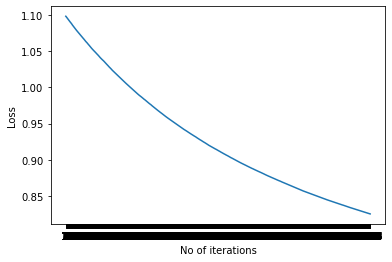

In [50]:
plotLoss(cost, no_epochs)

In [51]:
#predict labels
def predictLabels(dataMatrix, weightMatrix):  

    probablities = getProbablities(dataMatrix,weightMatrix )
    

    predictedLabels =  np.zeros((probablities.shape[0],1))
    
    for k in range(probablities.shape[0]):
        
        predictedLabels[k] = np.argmax(probablities[k,:])
        
    return predictedLabels
    

In [52]:
 #predict labels for test data
predictedLableTest =  predictLabels(testDataMatrix, weights)

In [53]:
# returns precision
def getPrecision(TP, FP):  
    return TP/(TP+FP)


In [54]:
# returns recall
def getRecall(TP,FN):   
    return TP/(TP+FN)

In [55]:
 # returns accuracy
def getAccuracy(TP,  total):  
    return TP/total


In [56]:
# function for evalution
def perf_measure(y_actual, y_pred):
    TP_Neutral = 0
    FP_Neutral = 0
    TN_Neutral = 0
    FN_Neutral = 0
    
    TP_Positive = 0
    FP_Positive = 0
    TN_Positive = 0
    FN_Positive = 0
    
    TP_Negative = 0
    FP_Negative = 0
    TN_Negative = 0
    FN_Negative = 0
    

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==0:
            TP_Neutral  += 1
        if y_actual[i]==y_pred[i]==1:
            TP_Positive  += 1
        if y_actual[i]==y_pred[i]==2:
            TP_Negative += 1
        
        if  y_actual[i]==0 and y_pred[i]!=0:
            FN_Neutral += 1
        if y_actual[i] ==1 and y_pred[i]!=1:
            FN_Positive += 1
        if y_actual[i]==2 and y_pred[i]!=2:
            FN_Negative += 1
        
        if  y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FP_Neutral += 1
        if  y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP_Positive += 1
        if  y_pred[i]==2 and y_actual[i]!=y_pred[i]:
            FP_Negative += 1
     
    precisionNeutral = getPrecision(TP_Neutral,FP_Neutral)
    precisionPositive = getPrecision(TP_Positive,FP_Positive)
    precisionNegative = getPrecision(TP_Negative,FP_Negative)
        
    recallNeutral = getRecall(TP_Neutral,FN_Neutral)
    recallPositive = getRecall(TP_Positive,FN_Positive)
    recallNegative =   getRecall(TP_Negative,FN_Negative)
        
    accuray =  getAccuracy((TP_Neutral+TP_Positive+TP_Negative), len(y_pred))
        
    print(f"Precision of Neutral:{precisionNeutral}")
    print(f"Precision of Positive:{precisionPositive}")
    print(f"Precision of Negative:{precisionNegative}")
        
    print(f"Recall of Neutral:{recallNeutral}")
    print(f"Recall of Positive:{recallPositive}")
    print(f"Recall of Negative:{recallNegative}")
        
    print(f"Overall Accuracy:{accuray}")

In [57]:
 # prints evaluation report
testLabels = np.array(testLabels, dtype = np.float)
perf_measure(testLabels,predictedLableTest)  

Precision of Neutral:0.6391554702495201
Precision of Positive:0.8009708737864077
Precision of Negative:0.6997929606625258
Recall of Neutral:0.7055084745762712
Recall of Positive:0.6991525423728814
Recall of Negative:0.7161016949152542
Overall Accuracy:0.7069209039548022
